In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda_methods import show_barplot, load_data, load_data_all
from pandas.plotting import register_matplotlib_converters

pd.set_option('display.max_colwidth', 125)
register_matplotlib_converters()

In [2]:
# IMPORTANT - Figure out how to correctly convert old hashes to new hashes

# project_name = 'zeppelin'
# try:
#     tmp =\
#         pd.read_csv(
#             'assets/data/{0}/new_{0}_commits.csv'.format(project_name),
#             nrows=None,
#             header=None
#         )
# except UnicodeDecodeError:
#     tmp =\
#         pd.read_csv(
#             'assets/data/{0}/new_{0}_commits.csv'.format(project_name),
#             nrows=None,
#             header=None,
#             encoding='utf-16'
#         )
# tmp = tmp.set_index(0).apply(pd.to_datetime, axis=1)
# tmp['dates_match'] = tmp.apply(lambda x: x.duplicated().sum(), axis=1).astype('bool')

# # finds
# grouped = tmp.groupby(2)
# g_index =\
#     [
#             x for x in grouped[1].apply(
#                 lambda x: pd.to_datetime(x[0], utc=True) 
#                 if (x.count() > 1).sum() else ''
#             ).values if x
#     ]
# tmp = tmp.reset_index().set_index(1)
# tmp.index = pd.to_datetime(tmp.index, utc=True, infer_datetime_format=True)

# transforms date column into datetime_index
# new_commits =\
#     pd.Series(
#         tmp[0].values,
#         index=pd.to_datetime(
#                 tmp[1].values,
#                 infer_datetime_format=True,
#                 utc=True
#             )
#     )
# new_commits.name = project_name

In [3]:
old, new, cc, bic = load_data_all()

In [4]:
# shows duplicated bug introducing commits (BIC) for each project
print('Total and duplicated bug introducing commits (BIC) for each project:\n\n\t\t\t(total, duplicated)')
bic.groupby(level=0).apply(lambda x: (x.count(), x.duplicated().sum()))

Total and duplicated bic for each project:

			(total, duplicated)


accumulo                      (3603, 2828)
activemq                      (8803, 7157)
ambari                      (47658, 40607)
avro                           (1099, 797)
beam                          (5690, 3538)
calcite                       (9083, 7843)
camel                        (10091, 6687)
cassandra                   (52036, 48730)
commons-lang                  (1503, 1003)
cordova-android                (1435, 922)
cxf                           (4902, 3446)
eagle                           (689, 456)
fineract                       (1051, 634)
flink                         (4421, 2765)
geode                        (10888, 9437)
groovy                      (17500, 14629)
james-project                  (1019, 511)
jena                            (930, 594)
kafka                         (1875, 1174)
karaf                         (1795, 1218)
kylin                         (3278, 2280)
lucene-solr                   (9854, 6606)
mahout                        (1824, 1198)
maven      

In [5]:
# removes duplicated BICs
print('Total BICs after removal of duplicates:\n')

project_bic = bic.groupby(level=0)

# saves unique BICs
ubic = project_bic.apply(lambda x: x.drop_duplicates(keep='first')).droplevel(0, axis=0)

print(ubic.groupby(level=0, axis=0).count())
del bic

Total BICs after removal of duplicates:

accumulo                     775
activemq                    1646
ambari                      7051
avro                         302
beam                        2152
calcite                     1240
camel                       3404
cassandra                   3306
commons-lang                 500
cordova-android              513
cxf                         1456
eagle                        233
fineract                     417
flink                       1656
geode                       1451
groovy                      2871
james-project                508
jena                         336
kafka                        701
karaf                        577
kylin                        998
lucene-solr                 3248
mahout                       626
maven                       1331
netbeans                      70
nifi                         896
nutch                        315
ofbiz                       1151
parquet-mr                   151
ph

In [6]:
'''
shows all conflicting 'created_at' commits
proceed with manual investigation of how to solve this (HUGE ISSUE!!!)
'''
# old.droplevel(0, axis=0)[old.droplevel(0, axis=0).index.duplicated(keep=False)]
# new.droplevel(0, axis=0)[new.droplevel(0, axis=0).index.duplicated(keep=False)]

"\nshows all conflicting 'created_at' commits\nproceed with manual investigation of how to solve this (HUGE ISSUE!!!)\n"

In [7]:
# new.reset_index().iloc[old.reset_index().index][0].values
'''
prints projects with different number of commits
'''
new_g = new.groupby(level=0)
old_g = old.groupby(level=0)

for ng, og in zip(new_g, old_g):
    # ng[1] = ng[1][ng[1].index.isin(og[1].index)]
    if len(ng[1])-1 != len(og[1]):
        print(ng[0], (len(ng[1]) - len(og[1]))-1)

camel 96
lucene-solr 30
netbeans 2


In [8]:
# new.reset_index().iloc[old.reset_index().index][0].values
'''
ensures that only commits present in 'old' are considered
'''
new_g = new.groupby(level=0)
old_g = old.groupby(level=0)
tmp = []

for ng, og in zip(new_g, old_g):
    tmp.append(ng[1][ng[1].index.isin(og[1].index)])

new = pd.concat(tmp)
del tmp
# del new_g, old_g

In [9]:
# aggregates old and new commits to facilitate conversion
convert = pd.DataFrame()

convert['old_hash'] = old
convert['new_hash'] =\
    new.reset_index()\
    .iloc[old.reset_index()\
    .index][0].values

# converts bic commits to their equivalent in 'new'
ubic =\
    convert.set_index('old_hash')\
    .squeeze()[ubic.values]\
    .dropna()\
    .reset_index(drop=True)

del convert

In [21]:
'''
selects relevant support count (>1) and confidence (>=0.5)
'''
# selects cochange of at least two components with confidence higher that 0.5
rcc = cc[
    (cc.support_count > 1) & (cc.confidence >= 0.5)
].reset_index(drop=True)

print(
    'Selects components with relevant cochange dependency\n',
    'Of {0} entries, {1} ({2:.2f}%) were found to have support_count > 1 and confidence >= 0.5'
    .format(len(cc), len(rcc), (100*len(rcc)/len(cc)))
)

del cc

Selects components with relevant cochange dependency
 Of 8932894 entries, 312681 (3.50%) were found to have support_count > 1 and confidence >= 0.5


In [102]:
import itertools

# operates with sets due to performance gains
set_rcc = set(itertools.chain.from_iterable(rcc['commit_hash'].values))
set_ubic = set(ubic.values)

# defines implicit functions to compute count and percentage metrics
get_bic_count = lambda x: len(set_ubic) - (len(set_ubic - set(x.values)))
get_bic_percent = lambda x: (len(set_ubic) - (len(set_ubic - set(x.values)))) / len(x)
get_cochange_count = lambda x: len(set_rcc) - (len(set_rcc - set(x.values)))
get_cochange_percent = lambda x: (len(set_rcc) - (len(set_rcc - set(x.values)))) / len(x)

# applies count functions over each group (project)
agg_count =\
    new_g.agg(['count', get_bic_count, get_bic_percent, get_cochange_count, get_cochange_percent])\
    .rename(columns={
        '<lambda_0>': 'bic_count', '<lambda_1>': 'bic_percent',
        '<lambda_2>': 'cochange_count', '<lambda_3>': 'cochange_percent'
        })

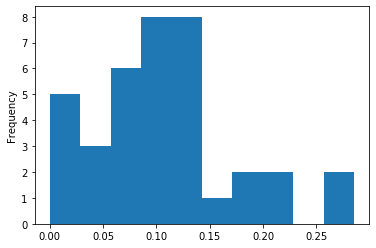

In [105]:
agg_count['bic_percent'].plot(kind='hist', bins=10)